### Question 3

In [156]:
import pickle
from collections import Counter
import numpy as np
import seaborn as sns
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import pandas as pd


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
from nltk.stem import PorterStemmer
# from wordcloud import STOPWORDS
import numpy as np
import nltk
nltk.download("stopwords")
stopword=stopwords.words('english')
# stops = set(stopwords.words('english'))
# for i in stops:
#     STOPWORDS.add(i)

ps = PorterStemmer()
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [157]:
classes = ['business', 'sport', 'politics', 'entertainment', 'tech']

In [158]:
train = pd.read_csv("BBC News Train.csv")
test = pd.read_csv("BBC News Test.csv")
train.drop_duplicates(subset=["Text"], inplace=True)
print(train.shape, test.shape)
train.drop(columns=['ArticleId'],inplace=True)
train.rename(columns = {'Category':'1','Text':'0'},inplace=True)
data=train

(1440, 3) (735, 2)


In [159]:
data

,0,1
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
...,...,...
1485,double eviction from big brother model caprice...,entertainment
1486,dj double act revamp chart show dj duo jk and ...,entertainment
1487,weak dollar hits reuters revenues at media gro...,business
1488,apple ipod family expands market apple has exp...,tech


In [160]:
def  processString(text):
  # print("___")
  symbols = "!\"#$%&()*+-./:;,<=>?@[\]^_`{|}~\n"
  for num in symbols:
    text = text.replace(num, " ")
    text = text.replace("  ", " ")
  text = text.replace("'", " ")
  text = text.replace("  ", " ")
  tokens_in_text = word_tokenize(text)
  for i in range(len(tokens_in_text)):
    token = tokens_in_text[i]
    token = token.strip()
    token = token.lower()
    token = ps.stem(token)
    tokens_in_text[i] = token;
  tokens_in_text =  [w for w in tokens_in_text if w not in stopword]
  return tokens_in_text

In [161]:
temp=[]
for i in train['0']:
    temp.append(processString(i))
train['0']=temp

In [162]:
data=train

In [163]:
#Splitting of data randomly depending on ratios
def spliting_data(data,ratio):
    rand_bool = np.random.rand(len(data)) < ratio
    train = data[rand_bool]
    test = data[~rand_bool]
    return train,test

In [164]:
def reset_index(train_data,test_data):
    train = train_data.reset_index(drop=True)
    test = test_data.reset_index(drop=True)
    train_class_split = Counter(train['1'])
    print(train_class_split)
    return train,test,train_class_split

In [165]:
#counting number of words in a perticular class
def class_words(train_data):
    word_dict= {}
    for i in train_data.index:
        try:
            word_dict[train_data['1'][i]] = word_dict[train_data['1'][i]] + train_data['0'][i]
        except:
            word_dict[train_data['1'][i]] = train_data['0'][i]
    return word_dict

In [166]:
 #counting number of UNIQUE words in a perticular class
def calulate_unique_word(word_dict):
    distinct_words = set()
    for i in word_dict:
        distinct_words = distinct_words | set(word_dict[i])
    distinct_words_c = len(distinct_words)
    return distinct_words,distinct_words_c

In [167]:
#class frequency for each word
def calculate_CF(word_dict):
    CF = {}

    #creating the list for each class
    for i in word_dict:
        for w in set(word_dict[i]):
            CF[w] = []

    for i in word_dict:
        for w in set(word_dict[i]):
            if i == 'business':
                CF[w].append(i)
            elif i == 'sport':
                CF[w].append(i)
            elif i == 'politics':
                CF[w].append(i)
            elif i == 'entertainment':
                CF[w].append(i)        
            else:
                CF[w].append(i)
    for k , v in CF.items():
        CF[k] = len(v)
    return CF

In [168]:
def class_freq(word,CF):
    rand = 0
    try:
        rand = CF[word]
    except:
        pass
    return rand

In [169]:
def calculate_tficf(word_dict,CF):
    tf_icf = {}
    N=5
    for i in word_dict:
        dumy_dict={}
        count=Counter(word_dict[i])
        w_count=len(word_dict[i])
        for word in set(word_dict[i]):
            term_freq = count[word]/w_count
            clas_freq = class_freq(word,CF)
            inv_class_freq = np.log((N)/(clas_freq))
            dumy_dict[word] = term_freq*inv_class_freq
        tf_icf[i] = dumy_dict
    return tf_icf

In [170]:
def tficf_k_feature(TF_ICF,feature_values):
    featTFICF=[]
    k_feature={}
    for i in TF_ICF.keys():
        c_feature=[]
        every_sk = sorted(TF_ICF[i], key=TF_ICF[i].get, reverse=True)
        for j in every_sk[0:int(feature_values)]:
            featTFICF.append(j)
            c_feature.append(j)
        k_feature[i] = c_feature
    return k_feature,featTFICF

In [171]:
def freq_count(classes,featTFICF,k_feature):
    class_f = {}
    class_c = {}

    for i in classes:
        counter_kFeature = Counter(k_feature[i])
        for j in featTFICF:
            class_f[i, j] = counter_kFeature[j]
            try:
                class_c[i] = class_c[i] + counter_kFeature[j]
            except:
                class_c[i] = counter_kFeature[j]
    return class_f,class_c

In [172]:
def frequency(word, label,class_f,class_c):
    try:
        return class_f[label, word], class_c[label]
    except:
        return 0, class_c[label]

In [173]:
#Naive Bayes classifier
def NaiveBayes(distinct_words_c,train_class_split,train_data,test_data,cls,class_f,class_c):
    true_values = []
    pred_values = []
    for i in range(test_data.shape[0]):
        true_values.append(test_data['1'][i])
        prob_classesWord = []
        for l in cls:
            prob_w = 0
            for w in test_data['0'][i]:
                freq, count = frequency(w, l,class_f,class_c)
                pp = (freq + 1) / (count + distinct_words_c)
                prob_w += np.log(pp)
            prob_w += np.log(train_class_split[l] / train_data.shape[0])            
            prob_classesWord.append(prob_w)           
        pred_values.append(cls[np.argmax(prob_classesWord)])        
    return true_values,pred_values

In [174]:
def accuracy(predicted, true):
    c = len([1 for i in range(len(predicted)) if predicted[i]==true[i]])
    return c/len(predicted)

In [175]:
def confusion_matrix(predicted, true,classes):
    confusion = np.zeros((len(classes), len(classes))).astype(int)
    for i in range(len(predicted)):
        confusion[classes.index(predicted[i])][classes.index(true[i])] += 1
    return confusion

In [176]:
def heatmap(conf_mat):
    sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues')

In [177]:
features = []
pref = []
train_size = []

In [178]:
def RunnerFunction(data,ratio):

    train_data,test_data = spliting_data(data,ratio)
    train_data,test_data,train_class_split = reset_index(train_data,test_data)
    word_dict = class_words(train_data)

    distinct_words,distinct_words_c = calulate_unique_word(word_dict)

    CF = calculate_CF(word_dict)
    tficf = calculate_tficf(word_dict,CF)
    feature_values = [10,20,40,60]
    for f_values in feature_values:
        k_feature,featTFICF = tficf_k_feature(tficf,f_values)
        class_f,class_c = freq_count(classes,featTFICF,k_feature)
        true_values,pred_values = NaiveBayes(distinct_words_c,train_class_split,train_data,test_data,classes,class_f,class_c)
        acc = accuracy(pred_values,true_values)
        print("Accuracy at %0.1f and at feature value %d : " % (ratio,f_values),acc)
        conf = confusion_matrix(pred_values,true_values,classes)
        print(conf)
        features.append(f_values)
        pref.append(acc)
        train_size.append(ratio)

In [179]:
ratios = [0.5,0.7,0.8]
for r in ratios:
    RunnerFunction(data,r)

Counter({'business': 166, 'sport': 165, 'politics': 143, 'entertainment': 123, 'tech': 118})
Accuracy at 0.5 and at feature value 10 :  0.7986206896551724
[[100   2   4   0   0]
 [ 58 174  20  24   8]
 [  6   0  95   3   6]
 [  1   1   2 112   4]
 [  4   0   2   1  98]]
Accuracy at 0.5 and at feature value 20 :  0.8441379310344828
[[113   1   1   0   0]
 [ 43 174   9  12   4]
 [  8   1 111   4   7]
 [  1   1   2 121  12]
 [  4   0   0   3  93]]
Accuracy at 0.5 and at feature value 40 :  0.886896551724138
[[131   1   1   2   1]
 [ 14 173   2   5   2]
 [ 13   3 117   8   7]
 [  3   0   3 122   6]
 [  8   0   0   3 100]]
Accuracy at 0.5 and at feature value 60 :  0.9144827586206896
[[142   1   3   0   4]
 [  5 176   0   4   1]
 [ 18   0 118   8   6]
 [  1   0   2 127   5]
 [  3   0   0   1 100]]
Counter({'sport': 238, 'business': 222, 'politics': 191, 'entertainment': 176, 'tech': 168})
Accuracy at 0.7 and at feature value 10 :  0.7842696629213484
[[ 70   1   6   1   0]
 [ 36 103  18  11 

In [180]:
res = PrettyTable()
res.field_names = ["% OF TRAINING DATA CONSIDERED", "FEATURES(TF-ICF BASED) SELECTED/CLASS ","ACCURACY"]
for i in range(len(train_size)):
    res.add_row([str(round(train_size[i]*100))+" %",str(round(features[i])), str(pref[i]*100)+" %"])
print(res)

+-------------------------------+----------------------------------------+---------------------+
| % OF TRAINING DATA CONSIDERED | FEATURES(TF-ICF BASED) SELECTED/CLASS  |       ACCURACY      |
+-------------------------------+----------------------------------------+---------------------+
|              50 %             |                   10                   | 79.86206896551724 % |
|              50 %             |                   20                   | 84.41379310344827 % |
|              50 %             |                   40                   |  88.6896551724138 % |
|              50 %             |                   60                   | 91.44827586206897 % |
|              70 %             |                   10                   | 78.42696629213484 % |
|              70 %             |                   20                   | 87.41573033707866 % |
|              70 %             |                   40                   | 91.23595505617978 % |
|              70 %           

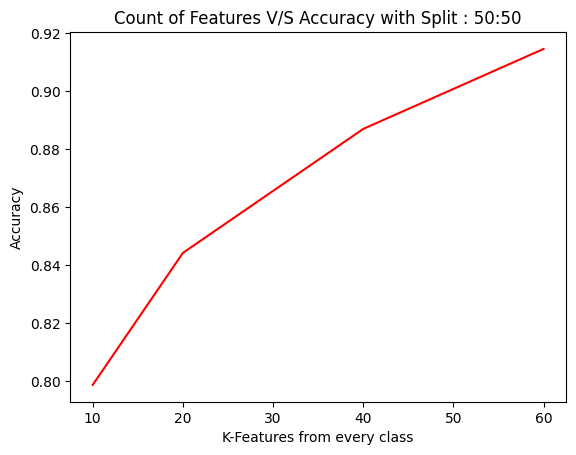

In [181]:
plt.plot(features[0:4],pref[0:4],color='red')
plt.xlabel("K-Features from every class")
plt.ylabel("Accuracy")
plt.title("Count of Features V/S Accuracy with Split : 50:50")
plt.show()

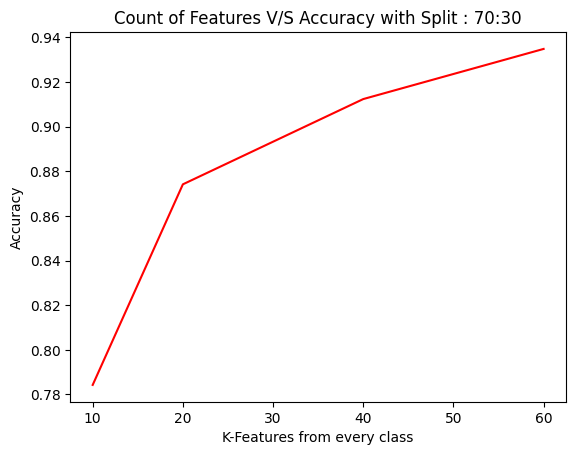

In [182]:
plt.plot(features[4:8],pref[4:8],color='red')
plt.xlabel("K-Features from every class")
plt.ylabel("Accuracy")
plt.title("Count of Features V/S Accuracy with Split : 70:30")
plt.show()

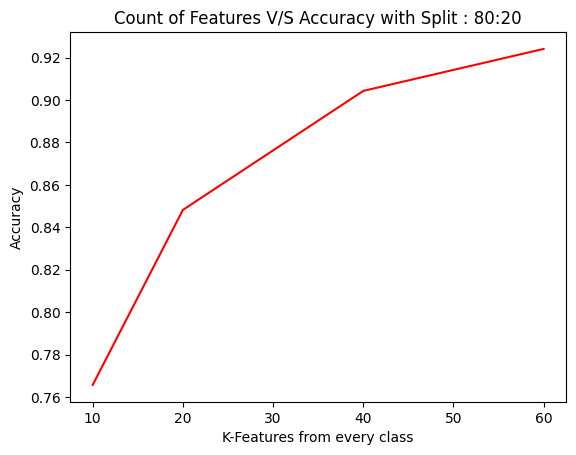

In [183]:
plt.plot(features[8:12],pref[8:12],color='red')
plt.xlabel("K-Features from every class")
plt.ylabel("Accuracy")
plt.title("Count of Features V/S Accuracy with Split : 80:20")
plt.show()

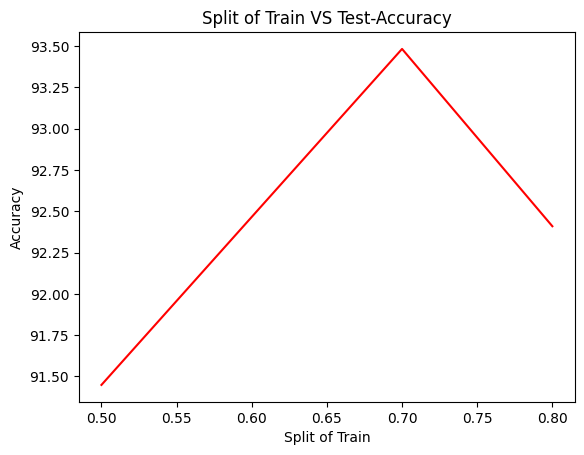

In [184]:
plt.plot([train_size[3],train_size[7],train_size[11]],[pref[3]*100,pref[7]*100,pref[11]*100],color='red')
plt.xlabel("Split of Train")
plt.ylabel("Accuracy")
plt.title("Split of Train VS Test-Accuracy")
plt.show()